In [4]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import bambi as bmb
SEED=123
from ElectionForecasting.src.data.polls.poll_forecasts import add_lags, cap_data, forecasts
from ElectionForecasting.src.root import ROOT_DIR
from ElectionForecasting.src.config import party_order

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
INFO:root:SETTING DATE TO 2023-10-27


In [5]:

data_store = 'data/interim/'
scenario = ''
interim_data_folder = Path(f"{ROOT_DIR}/{data_store}/{scenario}/")
processed_data_folder = Path(f"{interim_data_folder}/trends")
pickle_path = f'{interim_data_folder}/pickles/GAM_forecasts.pkl'
upper_range = 2024
election_year_data = {}
electoral_calendar = pd.read_csv(f'{ROOT_DIR}/data/dataland/dataland_electoral_calendar.csv')
electoral_calendar['election_day'] = pd.to_datetime(electoral_calendar['election_day'])

for year in list(map(str, range(1984, upper_range))):
    try:
        data = pd.read_csv(Path(f"{processed_data_folder}/{year}.csv"), index_col=0)
        election_day = electoral_calendar.loc[electoral_calendar.election_cycle == int(year)].election_day
        election_year_data[year] = add_lags(data, election_day)
    except FileNotFoundError:
        continue
share_cols = [c+'_poll_share' for c in party_order+['undecided']]
target_variable = 'cc_poll_share'
predictor_variable = target_variable + '_lag'
capped_election_year_data = cap_data(election_year_data)
# capped_evaluation_df, predictions_vs_reality = forecasts(capped_election_year_data)
data_select = capped_election_year_data['1984']
data = data_select.drop(columns=['index'])
data[target_variable] = data_select[target_variable]
data

,date,pdal_poll_share,dgm_poll_share,cc_poll_share,undecided_poll_share,ssp_poll_share,election_day,days_until_election,cc_poll_share_lag,ssp_poll_share_lag,dgm_poll_share_lag,pdal_poll_share_lag,undecided_poll_share_lag
0,1984-06-15,0.366536,0.267714,0.184964,0.101571,0.079143,1984-06-17,2,0.178214,0.075714,0.264643,0.368357,0.113071
1,1984-06-14,0.368357,0.264643,0.178214,0.113071,0.075714,1984-06-17,3,0.176786,0.079286,0.281786,0.354071,0.108071
2,1984-06-13,0.354071,0.281786,0.176786,0.108071,0.079286,1984-06-17,4,0.183929,0.080714,0.278929,0.349071,0.107357
3,1984-06-12,0.349071,0.278929,0.183929,0.107357,0.080714,1984-06-17,5,0.201143,0.085143,0.277000,0.334857,0.101857
4,1984-06-11,0.334857,0.277000,0.201143,0.101857,0.085143,1984-06-17,6,0.192929,0.082286,0.290929,0.324357,0.109500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1984-04-08,0.317500,0.230833,0.167500,0.210000,0.074167,1984-06-17,70,0.171000,0.074000,0.226000,0.321000,0.208000
69,1984-04-07,0.321000,0.226000,0.171000,0.208000,0.074000,1984-06-17,71,0.166250,0.075000,0.217500,0.340000,0.201250
70,1984-04-06,0.340000,0.217500,0.166250,0.201250,0.075000,1984-06-17,72,0.151667,0.071667,0.228333,0.346667,0.201667
71,1984-04-05,0.346667,0.228333,0.151667,0.201667,0.071667,1984-06-17,73,0.152500,0.067500,0.215000,0.377500,0.187500


In [6]:
data.to_csv('gam_training_data.csv')

In [7]:
import pymc as pm
import numpy as np
import pytensor.tensor as tt
import pandas as pd

# Load your data
df = data.copy()
# Prepare predictor and target variables
predictor_columns = ['cc_poll_share_lag', 'ssp_poll_share_lag', 
                     'dgm_poll_share_lag', 'pdal_poll_share_lag', 
                     'undecided_poll_share_lag', 'days_until_election']
target_columns = ['cc_poll_share', 'ssp_poll_share', 'pdal_poll_share', 'undecided_poll_share', 'dgm_poll_share']

predictors = df[predictor_columns].values
target = df[target_columns].values

# Define the Bayesian model
with pm.Model() as model:
    
    # Priors for fixed effects
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=len(target_columns))
    beta = pm.Normal('beta', mu=0, sigma=10, shape=(len(predictor_columns), len(target_columns)))
    
    # Linear model equation
    mu = alpha + pm.math.dot(predictors, beta)
    
    # Dirichlet likelihood
    likelihood = pm.Dirichlet('likelihood', a=tt.exp(mu), observed=target)

# Perform inference
with model:
    trace = pm.sample(1000, tune=1000)

# Summary of the model parameters
pm.summary(trace)


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
INFO:pymc.sampling.mcmc:NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 509 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 509 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maxim

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],6.652,4.149,-1.025,14.159,0.958,0.688,19.0,57.0,1.16
alpha[1],5.641,3.943,-1.320,13.149,0.533,0.379,56.0,212.0,1.07
alpha[2],4.946,3.945,-1.814,12.680,0.499,0.360,64.0,166.0,1.04
alpha[3],5.961,4.043,-1.106,13.973,0.413,0.293,96.0,144.0,1.03
alpha[4],5.474,4.072,-2.759,13.156,0.782,0.559,27.0,61.0,1.14
"beta[0, 0]",4.127,5.581,-5.974,14.506,1.250,0.897,20.0,81.0,1.16
"beta[0, 1]",0.507,4.736,-7.868,9.438,0.485,0.344,96.0,248.0,1.04
"beta[0, 2]",2.521,4.997,-6.528,11.928,0.632,0.449,63.0,170.0,1.05
"beta[0, 3]",1.680,5.451,-7.542,12.587,0.717,0.509,58.0,136.0,1.07
"beta[0, 4]",2.713,5.145,-6.773,12.747,0.674,0.479,58.0,175.0,1.08


In [11]:
import matplotlib.pyplot as plt

# Generate predictions based on the posterior samples
posterior_samples = pm.sample_posterior_predictive(trace, model=model)
posterior_samples = posterior_samples.posterior_predictive.likelihood.values
posterior_samples = posterior_samples.reshape([-1]+list(posterior_samples.shape[-2:]))
# Calculate the median and 95% prediction intervals
median_pred = np.median(posterior_samples, axis=0)
lower_pred = np.percentile(posterior_samples, 2.5, axis=0)
upper_pred = np.percentile(posterior_samples, 97.5, axis=0)

Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


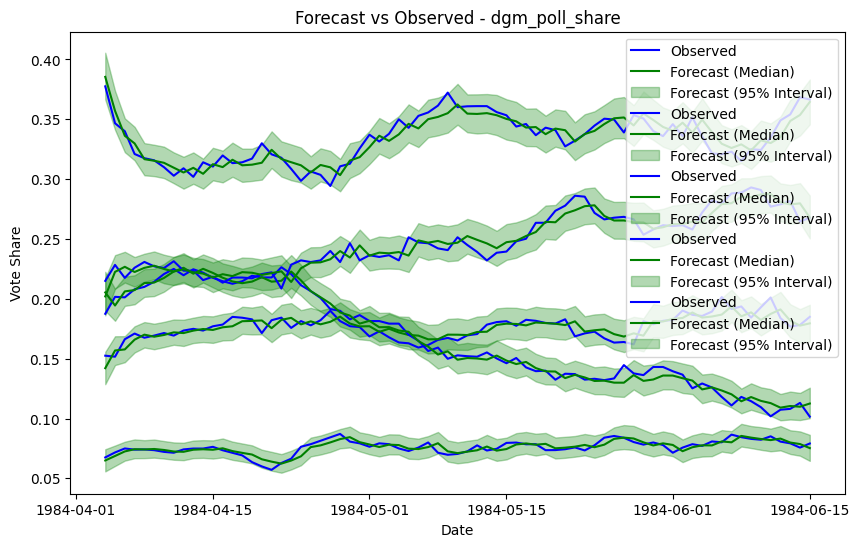

In [12]:

# Plot the forecasts along with the observed data
plt.figure(figsize=(10, 6))
for i, target_col in enumerate(target_columns):
    
    # Plot observed data
    plt.plot(df['date'], df[target_col], label='Observed', color='blue')
    
    # Plot median forecast
    plt.plot(df['date'], median_pred[:, i], label='Forecast (Median)', color='green')
    
    # Plot prediction intervals
    plt.fill_between(df['date'], lower_pred[:, i], upper_pred[:, i], color='green', alpha=0.3, label='Forecast (95% Interval)')
    
plt.title(f'Forecast vs Observed - {target_col}')
plt.xlabel('Date')
plt.ylabel('Vote Share')
plt.legend()
plt.show()


In [17]:
from patsy import dmatrix

DoF = 15
degree = 3

# Generate spline basis functions for 'days_until_election'
design_matrix = dmatrix(f"bs(days_until_election, df={DoF}, degree={degree}) - 1", data=df, return_type='dataframe')

# Update predictors to include spline terms
predictors_spline = df[predictor_columns].copy()
predictors_spline = pd.concat([predictors_spline, design_matrix], axis=1)
predictors_spline = predictors_spline.values

# Define the Bayesian model with splines
with pm.Model() as model_spline:
    
    # Priors for fixed effects
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=len(target_columns))
    beta = pm.Normal('beta', mu=0, sigma=10, shape=(predictors_spline.shape[1], len(target_columns)))
    
    # Linear model equation with spline terms
    mu = alpha + pm.math.dot(predictors_spline, beta)
    
    # Dirichlet likelihood
    likelihood = pm.Dirichlet('likelihood', a=tt.exp(mu), observed=target)

# Perform inference
with model_spline:
    trace_spline = pm.sample(1000, tune=1000)

# Summary of the model parameters
pm.summary(trace_spline)


Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
INFO:pymc.sampling.mcmc:NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 551 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 551 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3 divergences 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],6.772,3.910,-0.388,13.439,1.111,0.862,14.0,67.0,1.25
alpha[1],5.713,3.736,-1.704,11.476,0.832,0.597,20.0,26.0,1.16
alpha[2],7.251,4.238,-0.014,15.003,1.531,1.127,8.0,43.0,1.46
alpha[3],6.574,4.338,-1.572,14.863,0.941,0.675,22.0,63.0,1.15
alpha[4],5.668,3.835,-1.152,13.710,1.082,0.784,13.0,30.0,1.28
...,...,...,...,...,...,...,...,...,...
"beta[20, 0]",-1.531,2.667,-6.987,1.741,1.225,0.926,6.0,33.0,1.74
"beta[20, 1]",-0.241,1.565,-3.209,2.814,0.481,0.350,11.0,17.0,1.31
"beta[20, 2]",-2.870,2.006,-6.801,0.906,0.675,0.505,9.0,28.0,1.47
"beta[20, 3]",-1.930,2.808,-6.513,2.793,1.267,0.956,5.0,14.0,2.05


Sampling: [likelihood]
INFO:pymc.sampling.forward:Sampling: [likelihood]


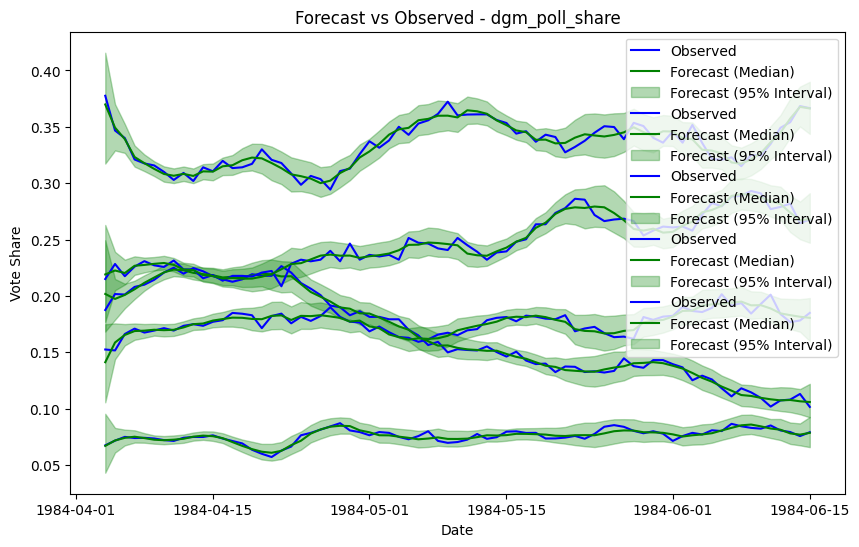

In [18]:
import matplotlib.pyplot as plt

# Generate predictions based on the posterior samples
posterior_samples = pm.sample_posterior_predictive(trace_spline, model=model_spline)
posterior_samples = posterior_samples.posterior_predictive.likelihood.values
posterior_samples = posterior_samples.reshape([-1]+list(posterior_samples.shape[-2:]))
# Calculate the median and 95% prediction intervals
median_pred = np.median(posterior_samples, axis=0)
lower_pred = np.percentile(posterior_samples, 2.5, axis=0)
upper_pred = np.percentile(posterior_samples, 97.5, axis=0)

# Plot the forecasts along with the observed data
plt.figure(figsize=(10, 6))
for i, target_col in enumerate(target_columns):
    
    # Plot observed data
    plt.plot(df['date'], df[target_col], label='Observed', color='blue')
    
    # Plot median forecast
    plt.plot(df['date'], median_pred[:, i], label='Forecast (Median)', color='green')
    
    # Plot prediction intervals
    plt.fill_between(df['date'], lower_pred[:, i], upper_pred[:, i], color='green', alpha=0.3, label='Forecast (95% Interval)')
    
plt.title(f'Forecast vs Observed - {target_col}')
plt.xlabel('Date')
plt.ylabel('Vote Share')
plt.legend()
plt.show()

1984-06-15 00:00:00
1984-06-07 19:12:00
1984-05-31 14:24:00
1984-05-24 09:36:00
1984-05-17 04:48:00
1984-05-10 00:00:00
1984-05-02 19:12:00
1984-04-25 14:24:00
1984-04-18 09:36:00
1984-04-11 04:48:00
1984-04-04 00:00:00


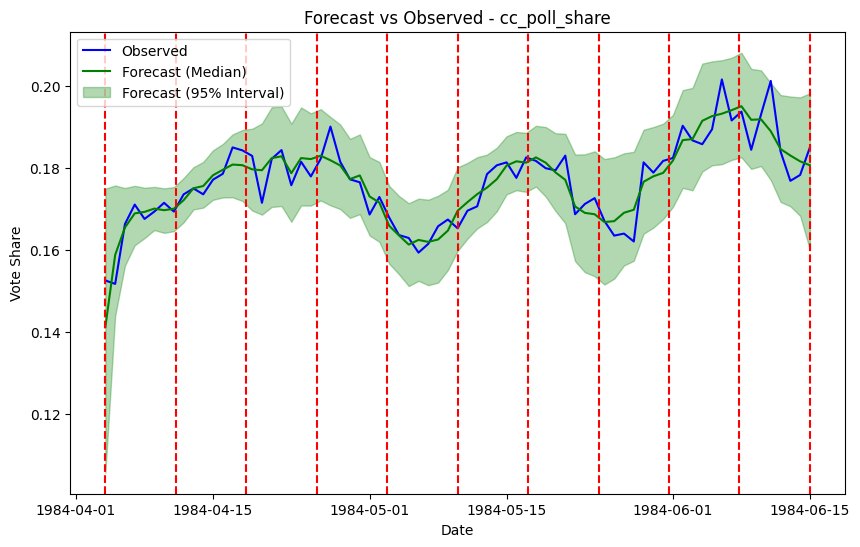

1984-06-15 00:00:00
1984-06-07 19:12:00
1984-05-31 14:24:00
1984-05-24 09:36:00
1984-05-17 04:48:00
1984-05-10 00:00:00
1984-05-02 19:12:00
1984-04-25 14:24:00
1984-04-18 09:36:00
1984-04-11 04:48:00
1984-04-04 00:00:00


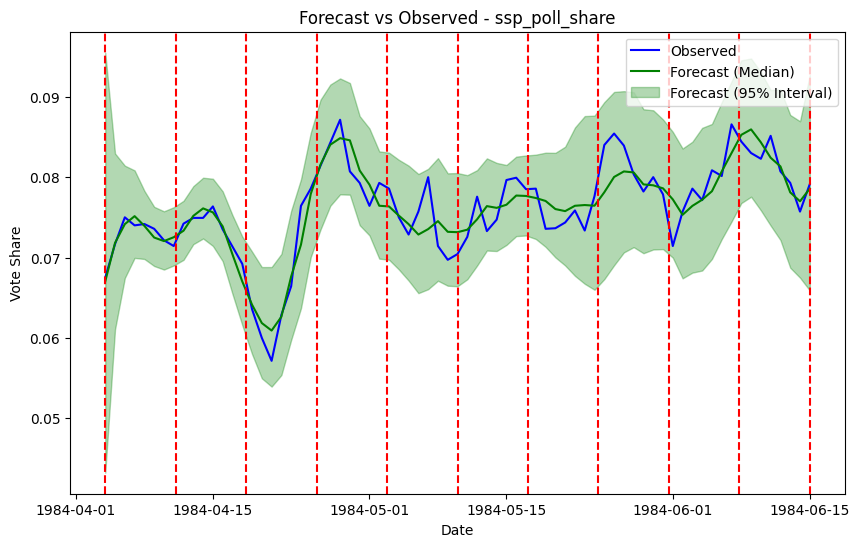

1984-06-15 00:00:00
1984-06-07 19:12:00
1984-05-31 14:24:00
1984-05-24 09:36:00
1984-05-17 04:48:00
1984-05-10 00:00:00
1984-05-02 19:12:00
1984-04-25 14:24:00
1984-04-18 09:36:00
1984-04-11 04:48:00
1984-04-04 00:00:00


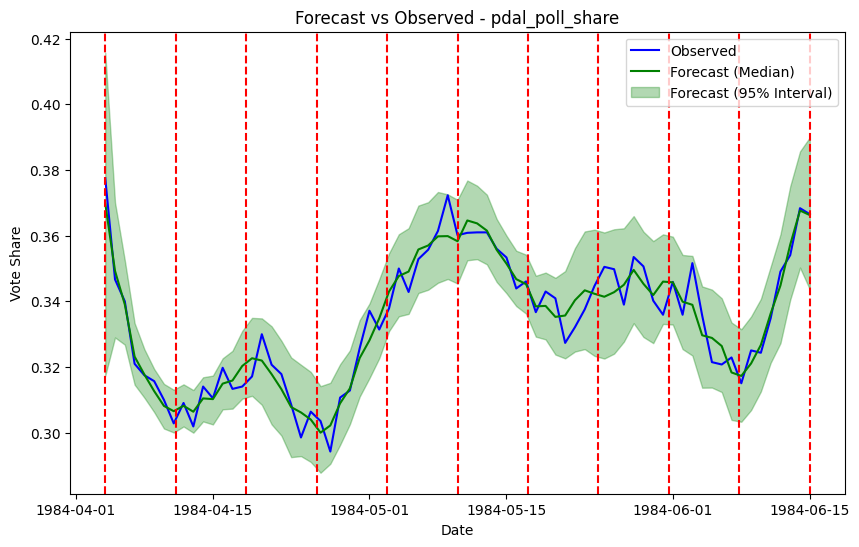

1984-06-15 00:00:00
1984-06-07 19:12:00
1984-05-31 14:24:00
1984-05-24 09:36:00
1984-05-17 04:48:00
1984-05-10 00:00:00
1984-05-02 19:12:00
1984-04-25 14:24:00
1984-04-18 09:36:00
1984-04-11 04:48:00
1984-04-04 00:00:00


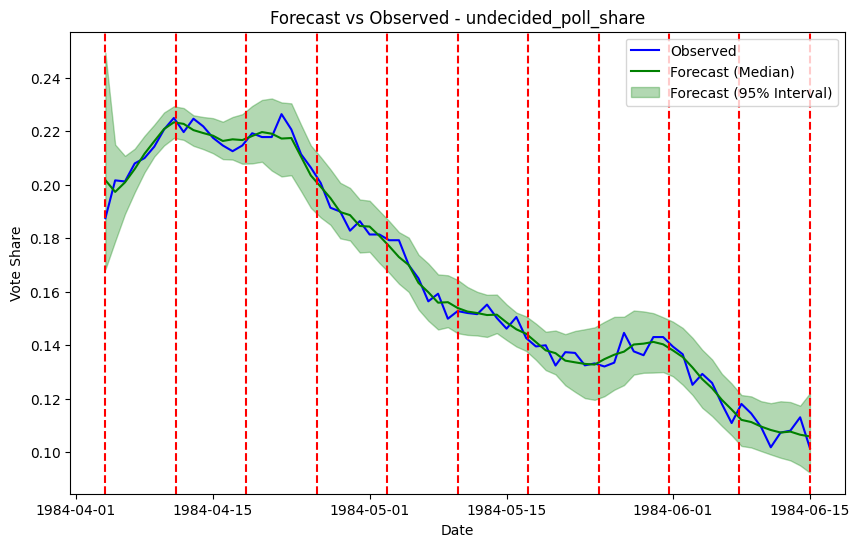

1984-06-15 00:00:00
1984-06-07 19:12:00
1984-05-31 14:24:00
1984-05-24 09:36:00
1984-05-17 04:48:00
1984-05-10 00:00:00
1984-05-02 19:12:00
1984-04-25 14:24:00
1984-04-18 09:36:00
1984-04-11 04:48:00
1984-04-04 00:00:00


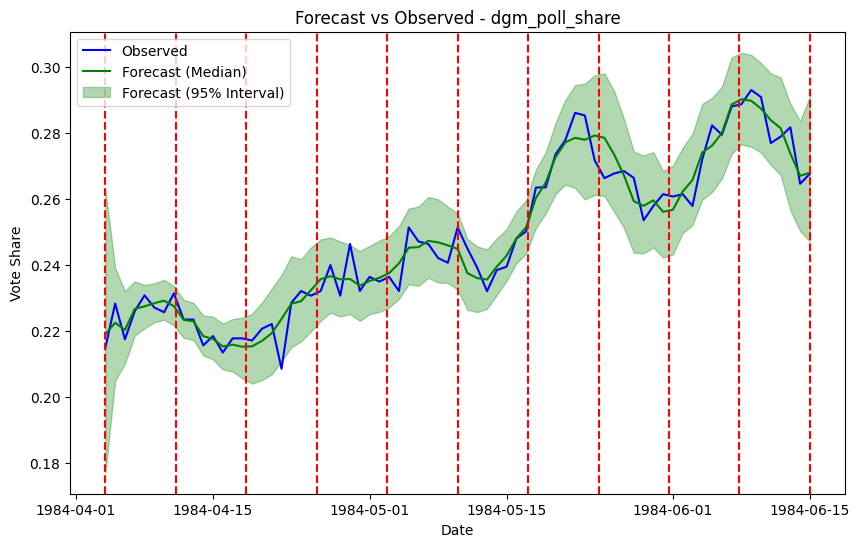

In [19]:
# Generate spline basis functions and identify knot locations
design_matrix = dmatrix("bs(days_until_election, df=5, degree=3, include_intercept=True) - 1", data=df, return_type='dataframe')
# Calculate the knot positions for 'days_until_election'
min_day = df['days_until_election'].min()
max_day = df['days_until_election'].max()

# Assuming 5 degrees of freedom, calculate 5 equally spaced knot positions
knots = np.linspace(min_day, max_day, DoF-degree-1)
election_date = pd.to_datetime(df['election_day'].unique()[0])

# Convert knot positions to dates
knot_dates = election_date - pd.to_timedelta(knots, unit='D')

# Plot the forecasts along with the observed data
for i, target_col in enumerate(target_columns):
    plt.figure(figsize=(10, 6))
    
    # Plot observed data
    plt.plot(df['date'], df[target_col], label='Observed', color='blue')
    
    # Plot median forecast
    plt.plot(df['date'], median_pred[:, i], label='Forecast (Median)', color='green')
    
    # Plot prediction intervals
    plt.fill_between(df['date'], lower_pred[:, i], upper_pred[:, i], color='green', alpha=0.3, label='Forecast (95% Interval)')
    
    # Plot the knot locations
    for knot in knot_dates:
        print(knot)
        plt.axvline(x=knot, color='red', linestyle='--', label='Knot' if knot == knots[0] else "")
    
    plt.title(f'Forecast vs Observed - {target_col}')
    plt.xlabel('Date')
    plt.ylabel('Vote Share')
    plt.legend()
    plt.show()


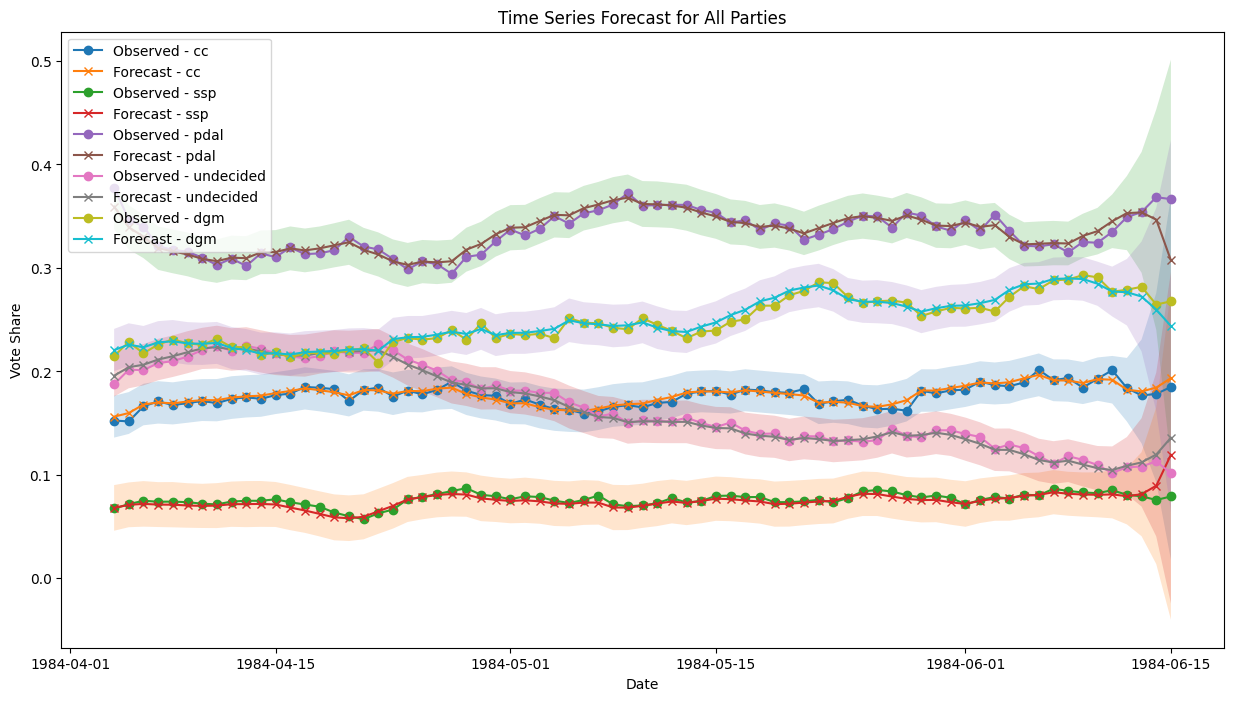

In [20]:
# Re-running the adjusted Particle Filter to include uncertainty estimates

# Observed vote shares
observations = df[['cc_poll_share', 'ssp_poll_share', 'pdal_poll_share', 'undecided_poll_share', 'dgm_poll_share']].values

# Number of particles
N = 10000

# Number of parties (based on the columns in the dataframe)
K = 5

# Initialize particles and weights
particles = np.random.dirichlet(np.ones(K), N)
weights = np.ones(N) / N

# Placeholder for forecasts and uncertainty estimates
forecasts = []
forecast_variances = []

# Loop over observations
for y in observations:
    # Prediction step: Evolve particles
    particles = 0.5 * particles + 0.5 * y + np.random.normal(0, 0.01, (N, K))
    particles = np.clip(particles, 0, 1)
    particles /= np.sum(particles, axis=1)[:, np.newaxis]
    
    # Update step: Update weights based on the Dirichlet likelihood
    likelihood = np.exp(np.sum((y - 1) * np.log(particles + 1e-10), axis=1))
    weights *= likelihood
    weights += 1e-10
    weights /= np.sum(weights)
    
    # Resampling step
    indices = np.random.choice(np.arange(N), size=N, p=weights)
    particles = particles[indices]
    weights = np.ones(N) / N
    
    # State estimation: Weighted mean of particles
    estimate = np.average(particles, axis=0, weights=weights)
    forecasts.append(estimate)
    
    # Uncertainty estimation: Weighted variance of particles
    variance = np.average((particles - estimate)**2, axis=0, weights=weights)
    forecast_variances.append(variance)

# Convert forecasts and variances to NumPy arrays
forecasts = np.array(forecasts)
forecast_variances = np.array(forecast_variances)

# Calculate the 95% confidence intervals for the forecasts
forecast_lower_bound = forecasts - 1.96 * np.sqrt(forecast_variances)
forecast_upper_bound = forecasts + 1.96 * np.sqrt(forecast_variances)

# Plotting the forecasts for each party
party_names = ['cc', 'ssp', 'pdal', 'undecided', 'dgm']  # Replace with your actual party names

# Plotting the forecasts and uncertainty for each party on a single axis
plt.figure(figsize=(15, 8))

for i, party in enumerate(party_names):
    # Plot the observed data
    plt.plot(df['date'], observations[:, i], label=f'Observed - {party}', marker='o')
    
    # Plot the forecasted data
    plt.plot(df['date'], forecasts[:, i], label=f'Forecast - {party}', marker='x')
    
    # Plot the 95% confidence interval for the forecast
    plt.fill_between(df['date'], forecast_lower_bound[:, i], forecast_upper_bound[:, i], alpha=0.2)

plt.title(f'Time Series Forecast for All Parties')
plt.xlabel('Date')
plt.ylabel('Vote Share')
plt.legend()
plt.show()
